In [2]:
# import trecs
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from chaney_utils import (
    load_sim_results,
    merge_results,
    graph_metrics,
    graph_relative_to_ideal,
)
from scipy.stats import dirichlet
DEBUG = True
id_to_readable = {
    "ideal": "ideal", 
    "target_ideal": "target ideal",
    "content_chaney": "content filtering basic",
    "content_chaney_j_1.0": "content filtering a=1.0",
    "content_chaney_j_3.0": "content filtering a=3.0",
    "content_chaney_j_0.5": "content filtering a=0.5",
    "popularity": "popularity", 
    "random": "random"
}

In [3]:
results = merge_results(["udpc_ouput"])

startup_iters = 50
sim_iters = 350
timesteps = startup_iters + sim_iters

In [4]:
target_profs = np.array(results['target_user_profiles']['ideal']) 
num_sims, num_steps, num_creators, num_attrs = target_profs.shape

actual_profs_strong_j = np.array(results['actual_user_profiles']['content_chaney_j_3.0']) 
actual_profs_normal_j = np.array(results['actual_user_profiles']['content_chaney_j_1.0'])
actual_profs_weak_j = np.array(results['actual_user_profiles']['content_chaney_j_0.5']) 

actual_profs_content = np.array(results['actual_user_profiles']['content_chaney']) 

actual_profs_ideal = np.array(results['actual_user_profiles']['ideal']) 
actual_profs_target_ideal = np.array(results['actual_user_profiles']['target_ideal']) 
actual_profs_rand = np.array(results['actual_user_profiles']['random'])
actual_profs_pop = np.array(results['actual_user_profiles']['popularity'])

In [9]:
actual_profs_ideal[0].shape

(400, 100, 20)

In [4]:
""" FUNCTIONS """
nA = 20 #number of atributes
width = 0.3 #for the bar plots
u = 0

def plot_profiles(ax, blue, model, b_ts=0, orange=target_profs, o_ts=0, user=u, norm_axis=True, norm_prefs=True, title="Start vs End Preferences of simulation", mid=None, colors=['orange', 'tab:blue']):    
    if norm_prefs and mid == None:
        ax.bar(np.arange(nA), normalize_preferences(blue[0, b_ts, user, :]), width, color=colors[0], label="$U$ at t={}".format(b_ts))
        ax.bar(np.arange(nA) + width, normalize_preferences(orange[0, o_ts, user, :]), width, color=colors[1], label='$U_{target}$')
    elif norm_prefs and mid != None:
        colors=["gold", "orange", "red"]
        # plots right to left
        ax.bar(np.arange(nA), normalize_preferences(blue[0, b_ts, user, :]), width, color=colors[0], label="$U$ at t={}".format(b_ts))
        ax.bar(np.arange(nA) + width, normalize_preferences(blue[0, mid, user, :]), width, color=colors[1], label="$U$ at t={}".format(mid))
        ax.bar(np.arange(nA) + width + width, normalize_preferences(blue[0, o_ts, user, :]), width, color=colors[2], label="$U$ at t={}".format(o_ts))
    elif mid != None:
        colors=["gold", "orange", "red"]
        # plots right to left
        ax.bar(np.arange(nA), blue[0, b_ts, user, :], width, color=colors[0], label="$U$ at t={}".format(b_ts))
        ax.bar(np.arange(nA) + width, blue[0, mid, user, :], width, color=colors[1], label="$U$ at t={}".format(mid))
        ax.bar(np.arange(nA) + width + width, blue[0, o_ts, user, :], width, color=colors[2], label="$U$ at t={}".format(o_ts))
    else:
        ax.bar(np.arange(nA), blue[0, b_ts, user, :], width, color=colors[0], label="$U$ at t={}".format(b_ts))
        ax.bar(np.arange(nA) + width, orange[0, b_ts, user, :], width, color=colors[1], label='$U_{target}$')
    
    if norm_axis:
        ax.set_ylim(0, 1) # to equalize the y axes
    ax.set_xticks(np.arange(nA) + width/2)
    ax.set_xticklabels(np.arange(nA)+1)
    ax.set_xlabel("Item Attribute Index")
    ax.set_ylabel("User Preference Distribution")
    ax.legend()
    ax.set_title(title)
    # ax.show()

def shannon_entropy(A):
    num_users = A.shape[0]
    avg_entropy = 0
    for i in range(num_users):
        assert A[i].sum() != 0
        # pA = A[i] / A[i].sum()
        pA = A[i]
        avg_entropy += -np.sum(pA*np.log2(pA))
    return avg_entropy / num_users

def calc_avg_entropy_per_timestep(results, model_keys, num_trials, num_timesteps):
    new_results = {}
    new_results['avg_creator_entropy'] = {}
    for model_key in model_keys:
        entropies = np.zeros((num_trials, num_timesteps))
        creator_profs = np.array(results['actual_user_profiles'][model_key])
        for i in range(num_trials):
            for j in range(num_timesteps):
                entropies[i, j] = shannon_entropy(creator_profs[i, j, :])
        new_results['avg_creator_entropy'][model_key] = entropies
    return new_results


# calculate Dirichlet moment
def normalize_preferences(dirichlet_params, multiplier = 0.1):
    """
    Calculate the average item profile for a given vector of parameters
    for the Dirichlet distribution. 
    Multiplier is set to 0.1 for sparsity.
    """
    multiplier = 1.0 
    a0 = (multiplier * dirichlet_params).sum()
    return (multiplier * dirichlet_params) / a0

def plot_single_profiles(blue, orange, blabel, olabel): 
    plt.bar(np.arange(nA), blue, width, label=blabel)
    plt.bar(np.arange(nA) + width, orange, width, label=olabel)
    plt.xticks(np.arange(nA) + width/2, np.arange(nA)+1)
    plt.xlabel("Item Attribute Index")
    plt.ylabel("User Preference Distribution")
    plt.legend()
    plt.show()
    

Ideal
Actual User Profiles [Start]: 	Entropy:	2.924015921182769	Similarity:	0.22873940544153903
Actual User Profiles [Mid]: 	Entropy:	2.119396881256931	Similarity:	0.1660564457668311
Actual User Profiles [End]: 	Entropy:	1.4226020905797199	Similarity:	0.13411053800708722


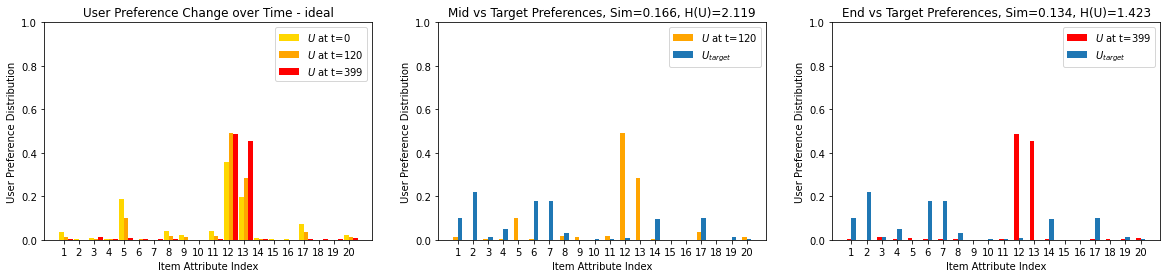

Target ideal
Actual User Profiles [Start]: 	Entropy:	2.924015921182769	Similarity:	0.22873940544153903
Actual User Profiles [Mid]: 	Entropy:	2.991544812750484	Similarity:	0.8144020604935333
Actual User Profiles [End]: 	Entropy:	1.5532555364121512	Similarity:	0.8779070173806426


<Figure size 432x288 with 0 Axes>

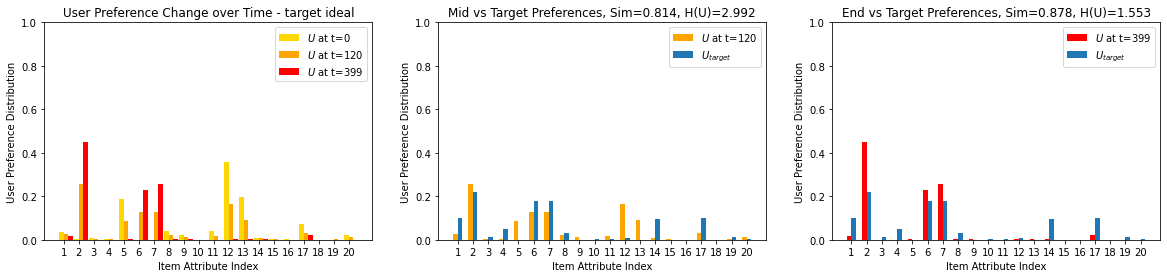

Content filtering basic
Actual User Profiles [Start]: 	Entropy:	2.924015921182769	Similarity:	0.22873940544153903
Actual User Profiles [Mid]: 	Entropy:	2.2212301078303467	Similarity:	0.1748110329078496
Actual User Profiles [End]: 	Entropy:	1.3258535102111724	Similarity:	0.13462882066753898


<Figure size 432x288 with 0 Axes>

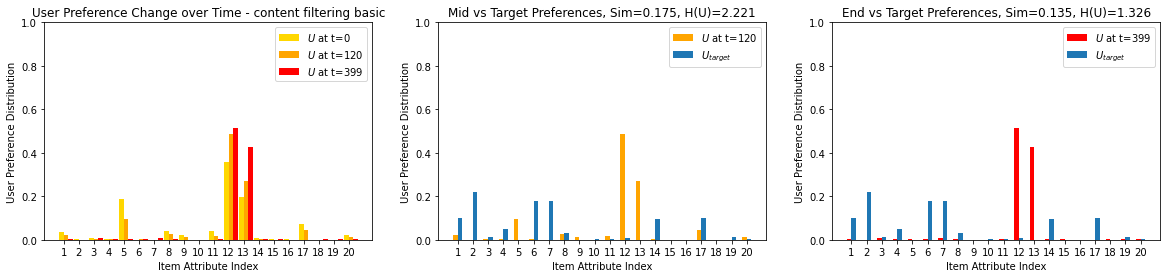

Content filtering a=3.0
Actual User Profiles [Start]: 	Entropy:	2.924015921182769	Similarity:	0.22873940544153903
Actual User Profiles [Mid]: 	Entropy:	2.724878127372961	Similarity:	0.7251674767335858
Actual User Profiles [End]: 	Entropy:	1.3877901592379225	Similarity:	0.8233007240890242


<Figure size 432x288 with 0 Axes>

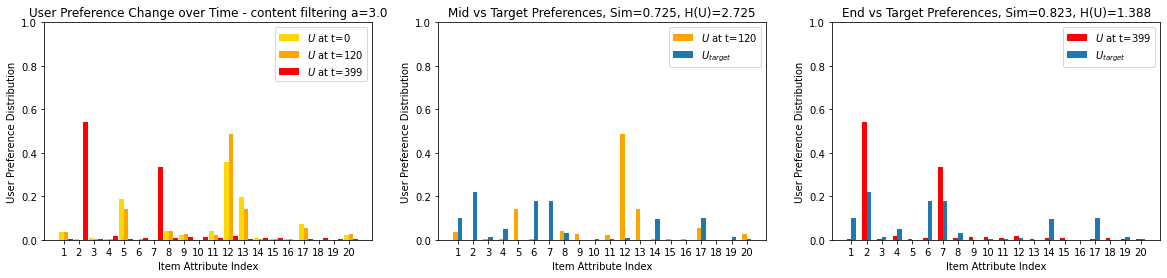

Content filtering a=1.0
Actual User Profiles [Start]: 	Entropy:	2.924015921182769	Similarity:	0.22873940544153903
Actual User Profiles [Mid]: 	Entropy:	2.707942512702185	Similarity:	0.6648284025024453
Actual User Profiles [End]: 	Entropy:	1.3988565344272013	Similarity:	0.7878328584505412


<Figure size 432x288 with 0 Axes>

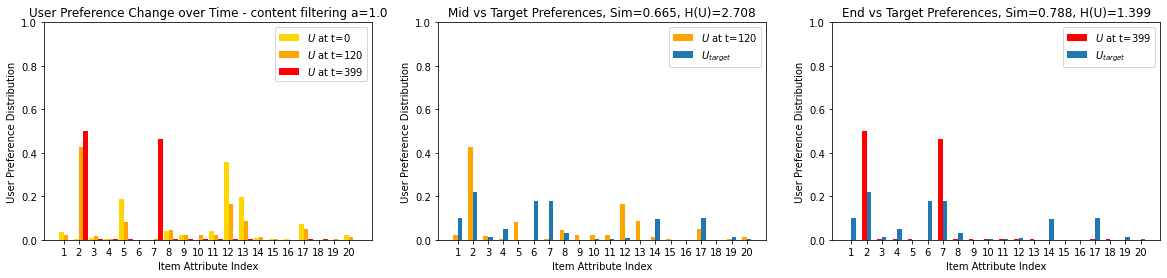

Content filtering a=0.5
Actual User Profiles [Start]: 	Entropy:	2.924015921182769	Similarity:	0.22873940544153903
Actual User Profiles [Mid]: 	Entropy:	2.42109910421732	Similarity:	0.3205760150988564
Actual User Profiles [End]: 	Entropy:	1.3771020878421334	Similarity:	0.3175518791098934


<Figure size 432x288 with 0 Axes>

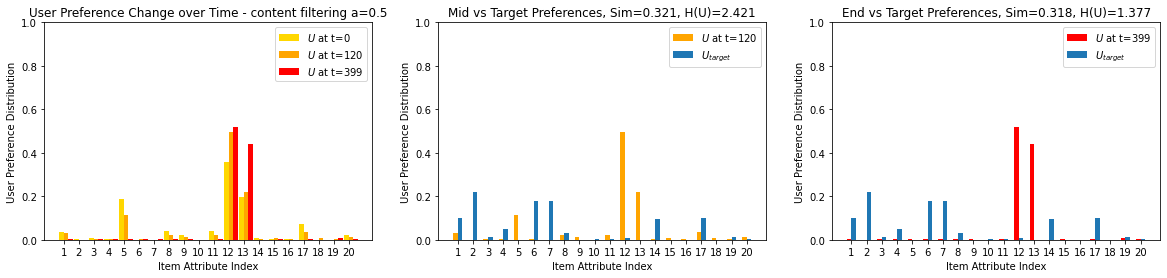

Random
Actual User Profiles [Start]: 	Entropy:	2.924015921182769	Similarity:	0.22873940544153903
Actual User Profiles [Mid]: 	Entropy:	3.065742219479323	Similarity:	0.23551237965608152
Actual User Profiles [End]: 	Entropy:	3.0567242773965795	Similarity:	0.25081754346656443


<Figure size 432x288 with 0 Axes>

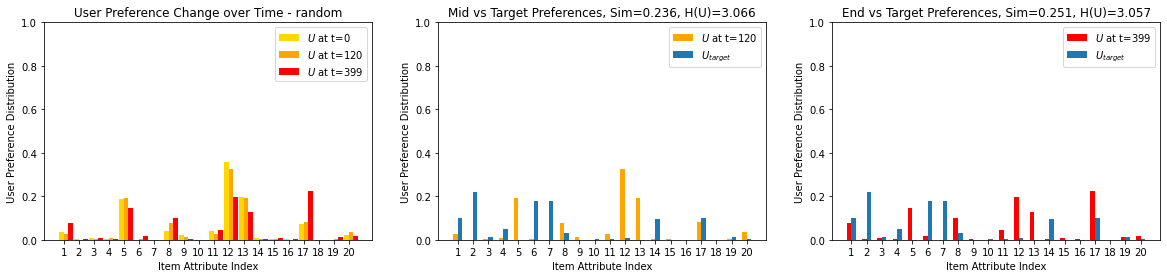

Popularity
Actual User Profiles [Start]: 	Entropy:	2.924015921182769	Similarity:	0.22873940544153903
Actual User Profiles [Mid]: 	Entropy:	2.2521511771552962	Similarity:	0.18715529499914388
Actual User Profiles [End]: 	Entropy:	1.456767055984626	Similarity:	0.1339967980735458


<Figure size 432x288 with 0 Axes>

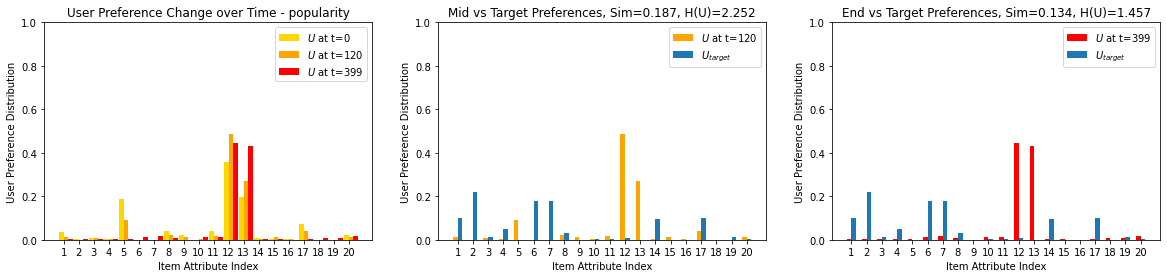

<Figure size 432x288 with 0 Axes>

In [5]:
""" Plotting the distribution and the corresponding entropies """

mid=120

def profile_stats(model_to_plot, label):
    print(label.capitalize())
    
    actual_entropy_start = shannon_entropy(model_to_plot[0, 0, :])
    actual_entropy_mid = shannon_entropy(model_to_plot[0, mid, :])
    actual_entropy_end = shannon_entropy(model_to_plot[0, timesteps-1, :])

    similarity_start = cosine_similarity(target_profs[0, 0, :], model_to_plot[u, 0, :]).diagonal().mean()
    similarity_mid = cosine_similarity(target_profs[0, 0, :], model_to_plot[u, mid, :]).diagonal().mean()
    similarity_end = cosine_similarity(target_profs[0, 0, :], model_to_plot[u, timesteps-1, :]).diagonal().mean()

    print("Actual User Profiles [Start]: ", "Entropy:", actual_entropy_start, "Similarity:", similarity_start, sep='\t')
    print("Actual User Profiles [Mid]: ", "Entropy:", actual_entropy_mid, "Similarity:", similarity_mid, sep= '\t')
    print("Actual User Profiles [End]: ", "Entropy:", actual_entropy_end, "Similarity:", similarity_end, sep='\t')
    
    fig, axs = plt.subplots(ncols=3, figsize=(20,4))
    
    plot_profiles(axs[0], model_to_plot, label, b_ts=0, o_ts=timesteps-1, user=u, title="User Preference Change over Time - {}".format(label), mid=mid)
    plot_profiles(axs[1], model_to_plot, label, b_ts=mid, orange=target_profs, o_ts=timesteps-1, user=u, title="Mid vs Target Preferences, Sim={}, H(U)={}".format(round(similarity_mid,3), round(actual_entropy_mid,3)))
    plot_profiles(axs[2], model_to_plot, label, b_ts=timesteps-1, orange=target_profs, o_ts=timesteps-1, user=u, title="End vs Target Preferences, Sim={}, H(U)={}".format(round(similarity_end,3),  round(actual_entropy_end,3)), colors=['red', 'tab:blue'])
    plt.show()
    plt.tight_layout()
    fig.savefig("figures/preference_change_visual_{}.pdf".format(model.replace(".", "-")), bbox_inches='tight')


    """ Plotting the shannon entropy of all models """
    
model_keys = ["ideal", "target_ideal", "content_chaney", "content_chaney_j_3.0", "content_chaney_j_1.0", "content_chaney_j_0.5", "random", "popularity"]

for model in model_keys:
    profile_stats(np.array(results['actual_user_profiles'][model]), id_to_readable[model])
   

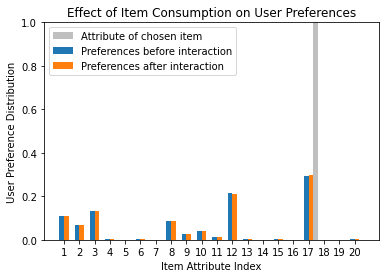

In [14]:
import trecs.matrix_ops as mo

pref_before_cons = np.array([0.10933025155582786, 0.06693451751652005, 0.13405619765107082, 0.0034325736324136882, 0.0001361879155451763, 0.0017306647853878472, 0.0000010001161261870374, 0.08656679650928405, 0.024921454642869784, 0.04183545382032431, 0.013219514363157695, 0.2142594737322412, 0.0018481457322445942, 0.0012766587672027017, 0.002469486498769603, 0.0003566138185409538, 0.29422373086726883, 0.0000000004615107068394732, 0.0000020536753738491855, 0.003399178248760172])
chosen_item_attr = np.zeros(nA) # approximately
chosen_item_attr[16] = 1.0

# pref_after_cons = np.array([0.10047405182807766, 0.06151254649412467, 0.12319709476862627, 0.003154521060172587, 0.00014969141730983372, 0.001590473824669604, 9.191026094484117e-07, 0.07955453019901906, 0.022902714388617098, 0.03844661011548137, 0.012148679367006567, 0.19690357574488104, 0.0016984383319795411, 0.0011732441599404378, 0.002269447942680501, 0.00032772678144062843, 0.317203805613459, 0.00000004241264427579216, 0.000001887319227879073, 0.003123830839851375])
pref_after_cons = mo.slerp(pref_before_cons, chosen_item_attr, perc=0.02)[0]

plt.bar(np.arange(nA)+width+width, chosen_item_attr, width, alpha=0.5, color="GREY", label="Attribute of chosen item")
plt.bar(np.arange(nA), pref_before_cons, width, label="Preferences before interaction")
plt.bar(np.arange(nA) + width, pref_after_cons, width, label="Preferences after interaction")
plt.ylim(0, 1.0)
plt.xticks(np.arange(nA) + width/2, np.arange(nA)+1)
plt.xlabel("Item Attribute Index")
plt.ylabel("User Preference Distribution")
plt.legend()
plt.title("Effect of Item Consumption on User Preferences")
# if not DEBUG:
plt.savefig("figures/preference_drift_visual.pdf")


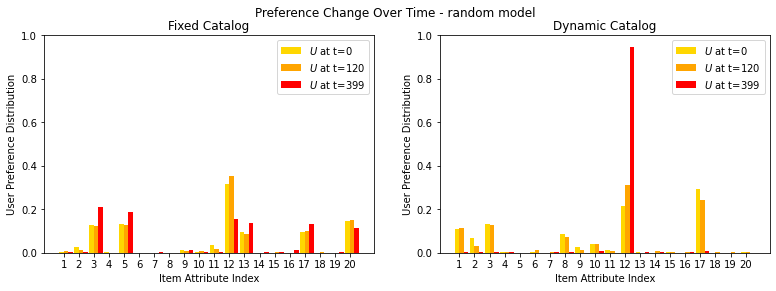

In [52]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13,4))

plot_profiles(ax=ax[0], blue=actual_profs_rand, model="random", b_ts=0, o_ts=timesteps-1, user=u, title="Fixed Catalog", mid=120)

results_dynamic = merge_results(["udps_ouput_creators"])
actual_profs_rand_dynamic = np.array(results_dynamic['actual_user_profiles']['random'])

plot_profiles(ax=ax[1], blue=actual_profs_rand_dynamic, model="random", b_ts=0, o_ts=timesteps-1, user=u, title="Dynamic Catalog", mid=120)
fig.suptitle("Preference Change Over Time - random model")

plt.savefig("figures/fixed_dynamic_preference_change_visual.pdf")

### Visualizing Incoporation of Meta-Preferences $M$

(20,)


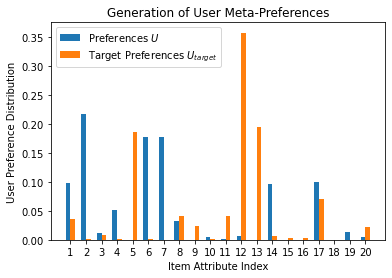

In [21]:
nA = 20
width = 0.3
pref_before_cons = target_profs[0, 0, 0, :]
pref_after_cons = actual_profs_ideal[0, 0, 0, :]

chosen_item_attr = np.subtract(pref_after_cons, pref_before_cons)
print(pref_before_cons.shape)

# plt.bar(np.arange(nA)+width+width, chosen_item_attr, width, alpha=0.5, color="GREEN", label="Meta-Preferences $M$")
plt.bar(np.arange(nA), pref_before_cons, width, label="Preferences $U$")
plt.bar(np.arange(nA) +width, pref_after_cons, width, label="Target Preferences $U_{target}$")
# plt.ylim(0, 1.0)
plt.xticks(np.arange(nA) + width/2, np.arange(nA)+1)
plt.xlabel("Item Attribute Index")
plt.ylabel("User Preference Distribution")
plt.legend()
plt.title("Generation of User Meta-Preferences")
# if not DEBUG:
plt.savefig("figures/metapreference_generation.pdf")

#### Visualizing The Creation of Meta-Preferences $M$

In [ ]:
# TODO